# Kickstarter Example (reworked)

## Imports

Here we import the necessary modules.

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Reading the data

Load the data from the `.csv` into a `DataFrame`.

In [2]:
PATH_ROOT = os.path.join('input', 'kickstarter-projects')
FLOC = os.path.join(PATH_ROOT, 'ks-projects-201801.csv')

In [3]:
df = pd.read_csv(FLOC, index_col='ID')
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Building a model

Let's build a `RandomForestClassifier` model!

### Preprocessing

Here we perform preprocessing steps which entails creating the feature space - a clean, processed version of the raw `df`.

In [4]:
# create a constant list of desired columns
COLUMNS = ['category', 'main_category', 
           'currency', 'goal', 'pledged', 
           'state', 'backers', 'country', 
           'usd pledged', 'usd_pledged_real', 
           'usd_goal_real']
# only select the desired columns, drop NaN and missing values
feature_space = df[COLUMNS].dropna()
feature_space.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374864 entries, 1000002330 to 999988282
Data columns (total 11 columns):
category            374864 non-null object
main_category       374864 non-null object
currency            374864 non-null object
goal                374864 non-null float64
pledged             374864 non-null float64
state               374864 non-null object
backers             374864 non-null int64
country             374864 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    374864 non-null float64
usd_goal_real       374864 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 34.3+ MB


In [5]:
# features
X = feature_space.drop('state', axis=1)
# labels
y = feature_space['state']

In [6]:
# define some preprocessor objects...
label_encoder = LabelEncoder()

# ...and apply fit_transform to our features
for col in X.select_dtypes(include='object').columns.values:
    X[col] = label_encoder.fit_transform(X[col])

X.head()

,category,main_category,currency,goal,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,
1000002330,108,12,5,1000.0,0.0,0,9,0.0,0.0,1533.95
1000003930,93,6,13,30000.0,2421.0,15,21,100.0,2421.0,30000.00
1000004038,93,6,13,45000.0,220.0,3,21,220.0,220.0,45000.00
1000007540,90,10,13,5000.0,1.0,1,21,1.0,1.0,5000.00
1000011046,55,6,13,19500.0,1283.0,14,21,1283.0,1283.0,19500.00


In [7]:
# Create the (stratified) train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Training

Here we instantiate and train the model on the test data.

In [8]:
%%time
# Let's just use the default parameters (10 estimators)
model = RandomForestClassifier()
model.fit(X_train, y_train)

C:\Users\donei\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 14.8 s


### Testing

How well does the model perform on the test data (unseen during training)?

In [9]:
model.score(X_test, y_test)

0.8608775449229588

Not bad... 86% accuracy. Can we optimize our model parameters for the chosen feature space?

### Model grid (`GridSearchCV`)

Let's make use of ScikitLearn's grid searching capabilities. **Warning**: Grid searching is a computationally expensive action - it will take a few minutes (at least) to run the full grid search.

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

In [11]:
%%time
# 5-fold cross validation... 
# (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation)
skf = StratifiedKFold(n_splits=10)

# here we define the parameter grid we wish to test.
# let's just vary a couple for the time being.
params = {'max_depth': [10, 20, 30], 'n_estimators': [10, 20, 30]}

# choose the type of model to use in grid searching
model = RandomForestClassifier()

# establish and fit the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=params, 
                    cv=skf, 
                    refit=True,
                    return_train_score=True,
                    scoring=make_scorer(accuracy_score))
grid.fit(X_train, y_train)

Wall time: 1h 10min 7s


In [12]:
# print out the optimal parameters found by the grid search
print('Best parameters found: {}'.format(grid.best_params_))

Best parameters found: {'max_depth': 10, 'n_estimators': 20}


In [13]:
accuracy_score(y_test, grid.predict(X_test))

0.8812475991292842

We were able to increase our test-set accuracy by 2% by doing a small grid search... The grid can become more granular, and maybe some better results will be found. Let's look at a confusion matrix for our predictions.

In [14]:
# show confusion matrix
predicted_base = 'Predicted {}'
actually_base = 'Actually {}'
label_vals = [v for v in y.value_counts().index]
cm = confusion_matrix(y_test, grid.predict(X_test))
cm_frame = pd.DataFrame(cm, columns=[predicted_base.format(v) for v in label_vals],
                            index=[actually_base.format(v) for v in label_vals])
cm_frame.head()

,Predicted failed,Predicted successful,Predicted canceled,Predicted live,Predicted suspended
Actually failed,7,9429,0,253,0
Actually successful,5,49119,0,279,0
Actually canceled,0,570,0,130,0
Actually live,0,2,0,33461,0
Actually suspended,0,368,0,93,0


Here the problem of class imbalance becomes especially apparent - our model **doesn't predict *any* canceled or suspended projects**... This is most likely because these classes are severly under-represented in the data.

## Digging deeper

Let's reload the original dataset and perform more intense preprocessing. No more sections here, everything in a single block.

We'll build a class that encapsulates the Kickstarter modeling problem and provides utility methods.

In [334]:
class KickstarterModel(object):
    
    def __init__(self, floc=FLOC):
        self._data = pd.read_csv(floc, index_col='ID', parse_dates=['launched', 'deadline'])
        self._restore = self._data.copy(deep=True)
        self._transforms = []
        
    def select_columns(self, cols=['category', 'main_category', 
                                   'currency', 'state', 'backers', 
                                   'country', 'usd_pledged_real', 
                                   'usd_goal_real'], info=True):
        '''Selects a subset of columns from the data.

        If a column list is not supplied, a default list of columns
        is created.

        Parameters
        ----------
            cols (optional) : the columns to select

        Returns
        -------
            self : returns this KickstarterModel object for cascading calls
        '''
        # only select the desired columns, drop NaN and missing values
        self._data = self._data[cols].dropna()
        if info:
            self._data.info()
        self._transforms.append('Drop NaN')
        self._transforms.append('Select cols: {}'.format(cols))
        return self
    
    def data(self, ascopy=True):
        if ascopy:
            return self._data.copy(deep=True)
        return self._data
    
    def label_encode(self):
        '''Performs label encoding on the data

        Returns
        -------
            self : returns this KickstarterModel object for cascading calls
        '''
        label_encoder = LabelEncoder()

        for col in self._data.select_dtypes(include='object').columns.values:
            self._data[col] = label_encoder.fit_transform(self._data[col])

        self._transforms.append('Encode categorical columns')
        return self
    
    def impute_backers(self):
        '''Performs a variation of mean-imputation on the backers column

        Returns
        -------
            self : returns this KickstarterModel object for cascading calls
        '''      
        ok = self._data.loc[(self._data['usd_pledged_real'] > 0) & (self._data['backers'] > 0)]
        ok_idx = ok.index
        mean = np.mean(ok['usd_pledged_real'] / ok['backers'])

        def _impute(row):
            row['backers'] = np.ceil(row['usd_pledged_real'] / mean).astype('int')
            return row

        self._data[~self._data.index.isin(ok_idx.values)] = \
            self._data[~self._data.index.isin(ok_idx.values)].apply(lambda row: _impute(row), axis=1)

        def _calc_avg_pledge(row):
            if row['backers'] > 0 and row['usd_pledged_real'] > 0:
                return row['usd_pledged_real'] / row['backers']
            return 0

        self._data['average_pledge'] = self._data.apply(lambda row: _calc_avg_pledge(row), axis=1)
    
        return self
    
    def boxcox_numerical(self):
        '''Performs a boxcox transformation on the numerical features in the data.

        Returns
        -------
            self : returns this KickstarterModel object for cascading calls
        '''
        self._data.loc[:, self._data.dtypes == np.float64] = \
            scipy.stats.boxcox(self._data.loc[:, self._data.dtypes == np.float64] + 1, 0)
        self._transforms.append('Boxcox')
        return self
    
    def plot_numerical_distributions(self, figx=8, figy=8):
        '''Shows value distributions for the numerical (float) valued columns in the data.'''
        numerical_features = self._data.loc[:, self._data.dtypes == np.float64]

        n_numerical_features = len(numerical_features.columns)

        fig, axes = plt.subplots(n_numerical_features, 1, figsize=(figx, figy * n_numerical_features))
        for i, c in enumerate(numerical_features.columns.values):
            axes[i].hist(numerical_features[c], bins=75)
            axes[i].set_title(c)
    
    def restore(self):
        '''Restores the model back to the extraction step - undos all transformations and model training'''
        self._transforms = []
        self.model_ = None
        self.train_preds_ = None
        self.test_preds_ = None
        self._data = self._restore.copy(deep=True)
    
    def split_features_and_labels(self):
        '''Decouples and returns the features and labels in the dataset as a tuple (features, labels,)'''
        X = self._data.drop('state', axis = 1)
        y = self._data['state']
        
        return X, y
    
    def train(self, n_estimators=25, max_depth=20, folds=None, show_cm=True):
        '''Trains and validates a RandomForestClassifier.

        Parameters
        ----------
            X : the feature space
            y : the corresponding labels
            n_estimators : the number of trees in the forest
            max_depth : the maximum depth to use in the decision trees
            kfolds : whether or not to use k-fold cross validation
            show_cm : whether or not to calculate and display the confusion matrix
                      on the test data
        '''
        print('Training model...')
        
        X, y = self.split_features_and_labels()
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)

        if folds:
            skf = StratifiedKFold(n_splits=folds)
            cv_score = cross_val_score(model, X_train, y_train, cv=skf)
            print('Cross validation result: {}'.format(cv_score))
            print('Refitting...')

        model.fit(X_train, y_train)
        
        self.model_ = model
        
        self.train_preds_ = model.predict(X_train)
        self.test_preds_ = model.predict(X_test)

        print('Model accuracy:\nTrain set:{train}\n'
              'Test set: {test}\n\n'
              .format(train=accuracy_score(y_train, self.train_preds_),
                      test=accuracy_score(y_test, self.test_preds_)))

        if show_cm:
            predicted_base = 'Predicted {}'
            actually_base = 'Actually {}'
            label_vals = [v for v in y.value_counts().index]

            cm = confusion_matrix(y_test, self.test_preds_)

            ax = plt.gca()
            sns.heatmap(cm, annot=True, fmt='g', ax=ax)

            ax.xaxis.set_ticklabels([actually_base.format(v) for v in label_vals], rotation=45)
            ax.yaxis.set_ticklabels([predicted_base.format(v) for v in label_vals], rotation=0)
    
    def print_transforms(self):
        phrase = '\n'.join(['{num}. {trans}'.format(num=i+1, trans=t) for i, t in enumerate(self._transforms)])
        print(phrase)

In [196]:


from IPython.display import display, HTML
from sklearn.model_selection import cross_val_score

def csv_to_df(floc):
    '''Extracts the contents of the raw .csv file into a DataFrame. '''
    return pd.read_csv(floc, index_col='ID', parse_dates=['launched', 'deadline'])

def select_columns(df, cols=['category', 'main_category', 
                             'currency', 'state', 'backers', 
                             'country', 'usd_pledged_real', 
                             'usd_goal_real', 'launched', 'deadline']):
    '''Selects a subset of columns from a DataFrame.
    
    If a column list is not supplied, a default list of columns
    is created.
    
    Parameters
    ----------
        df              : the DataFrame from which to select the specified columns
        cols (optional) : the columns to select
    
    Returns
    -------
        res : the resulting DataFrame after subselection of supplied columns
    '''
    # only select the desired columns, drop NaN and missing values
    res = df[cols].dropna()
    res.info()
    return res

def split_features_and_labels(df):
    '''Splits a DataFrame into features and labels
    
    Parameters
    ----------
        df : the DataFrame to split into features and labels
        
    Returns
    -------
        X : the features
        y : the corresponding labels
    '''
    X = df.drop('state', axis=1)
    # labels
    y = df['state']

    return X, y


def label_encode(X):
    '''Performs label encoding on a DataFrame
    
    Parameters
    ----------
        X : the feature space to perform encoding on
    
    Returns
    -------
        X : the encoded feature space
    '''
    label_encoder = LabelEncoder()
    
    for col in X.select_dtypes(include='object').columns.values:
        X[col] = label_encoder.fit_transform(X[col])
    
    print('\nCategorical labels encoded.')
    return X

def impute_backers(X):
    '''Performs a variation of mean-imputation on the backers column
    
    Parameters
    ----------
        X : the feature space to perform imputation on
    
    Returns
    -------
        X : the imputed feature space
    '''
    ok = X.loc[(X['usd_pledged_real'] > 0) & (X['backers'] > 0)]
    ok_idx = ok.index
    mean = np.mean(ok['usd_pledged_real'] / ok['backers'])

    def _impute(row):
        row['backers'] = np.ceil(row['usd_pledged_real'] / mean).astype('int')
        return row

    X[~X.index.isin(ok_idx.values)] = \
        X[~X.index.isin(ok_idx.values)].apply(_impute, axis=1)
    
    def calc_avg_pledge(row):
        if row['backers'] > 0 and row['usd_pledged_real'] > 0:
            return row['usd_pledged_real'] / row['backers']
        return 0

    X['average_pledge'] = X.apply(calc_avg_pledge, axis=1)
    print('\n`backers` column imputed.')
    return X


def boxcox_numerical(X):
    '''Performs a boxcox transformation on the numerical features in the supplied DataFrame.
    
    Parameters
    ----------
        X : the feature space to perform the boxcox transformation on
    
    Returns
    -------
        X : the feature space with the transformed columns
    '''
    X.loc[:, X.dtypes == np.float64] = scipy.stats.boxcox(X.loc[:, X.dtypes == np.float64] + 1, 0)
    return X
    

def calculate_time_delta(X):
    '''Adds a column to the supplied dataframe representing the time delta
    between the launch date and the deadline of the project.
    
    Parameters
    ----------
        X : the feature space to perform the time delta calculation on
    
    Returns
    -------
        X : the feature space with the new column
    '''
    X['launch_deadline_delta'] = (X['deadline'] - X['launched']).dt.days
    print('\nLaunch_deadline_delta column added.')
    return X

def grid_search(X, y, param_grid, folds=10, show_cm=True):
    '''Trains and validates a grid RandomForestClassifier models, choosing the model
    which give the best results.
    
    Parameters
    ----------
        X : the feature space
        y : the corresponding labels
        n_estimators : the number of trees in the forest
        max_depth : the maximum depth to use in the decision trees
        kfolds : whether or not to use k-fold cross validation
        show_cm : whether or not to calculate and display the confusion matrix
                  on the test data
    '''
    print('\n Training model...')
    
    _X = X.copy(deep=True)
    _X = _X.drop(['launched', 'deadline'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(_X, y, stratify=y)
    model = None
    skv = StratifiedKFold(n_splits=folds)

    model = GridSearchCV(estimator=RandomForestClassifier(),
                        param_grid=param_grid,
                        cv=skf, 
                        refit=True,
                        return_train_score=True,
                        scoring=make_scorer(accuracy_score))
    
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print('Model accuracy:\nTrain set:{train}\nTest set: {test}\n\n'
          .format(train=accuracy_score(y_train, train_preds),
                  test=accuracy_score(y_test, test_preds)))
    
    if show_cm:
        predicted_base = 'Predicted {}'
        actually_base = 'Actually {}'
        label_vals = [v for v in y.value_counts().index]
        cm = confusion_matrix(y_test, test_preds)
        cm_frame = pd.DataFrame(cm, columns=[predicted_base.format(v) for v in label_vals],
                                    index=[actually_base.format(v) for v in label_vals])
        display(HTML(cm_frame.to_html()))
    

def train(X, y, n_estimators=25, max_depth=20, folds=None, show_cm=True):
    '''Trains and validates a RandomForestClassifier.
    
    Parameters
    ----------
        X : the feature space
        y : the corresponding labels
        n_estimators : the number of trees in the forest
        max_depth : the maximum depth to use in the decision trees
        kfolds : whether or not to use k-fold cross validation
        show_cm : whether or not to calculate and display the confusion matrix
                  on the test data
    '''
    print('\nTraining model...')
    _X = X.copy(deep=True)
    _X = _X.drop(['launched', 'deadline'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(_X, y, stratify=y)
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
    
    if folds:
        skf = StratifiedKFold(n_splits=folds)
        cv_score = cross_val_score(model, X_train, y_train, cv=skf)
        print('Cross validation result: {}'.format(cv_score))
        print('Refitting...')

    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print('Model accuracy:\nTrain set:{train}\n'
          'Test set: {test}\n\n'
          .format(train=accuracy_score(y_train, train_preds),
                  test=accuracy_score(y_test, test_preds)))

    if show_cm:
        predicted_base = 'Predicted {}'
        actually_base = 'Actually {}'
        label_vals = [v for v in y.value_counts().index]
        
        cm = confusion_matrix(y_test, test_preds)
        
        ax = plt.gca()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax)
        
        ax.xaxis.set_ticklabels([actually_base.format(v) for v in label_vals], rotation=45)
        ax.yaxis.set_ticklabels([predicted_base.format(v) for v in label_vals], rotation=0)
        

### Exploratory Analysis

In [104]:
def extraction():
    df = csv_to_df(FLOC)
    df = select_columns(df)
    X, y = split_features_and_labels(df)
    return X, y

def preprocessing(X):
    X = label_encode(X)
    X = impute_backers(X)
    X = calculate_time_delta(X)
    return X

In [169]:
%%time
X, y = extraction()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 10 columns):
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
launched            378661 non-null datetime64[ns]
deadline            378661 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 31.8+ MB
Wall time: 7.31 s


In [170]:
%%time
X = preprocessing(X)


Categorical labels encoded.

`backers` column imputed.

Launch_deadline_delta column added.
Wall time: 40.6 s


In [252]:
X.average_pledge.value_counts()

0.000000      52527
1.000000       8545
25.000000      4744
10.000000      4199
5.000000       3155
50.000000      2874
20.000000      2787
100.000000     2067
15.000000      1996
30.000000      1732
35.000000      1073
40.000000      1023
3.000000        915
13.000000       874
75.000000       835
5.500000        754
17.500000       743
55.000000       716
60.000000       661
37.500000       657
62.500000       611
45.000000       610
27.500000       543
2.000000        490
7.500000        448
25.500000       429
22.500000       426
10.500000       401
18.000000       381
33.333333       379
              ...  
120.122200        1
12.066667         1
41.019608         1
651.810000        1
111.794052        1
142.467273        1
86.788462         1
112.652174        1
263.823529        1
42.631356         1
142.359012        1
728.513514        1
55.753247         1
43.736923         1
24.390183         1
42.003000         1
76.936170         1
33.780488         1
38.906364         1


When we look at the histograms for our numerical features, we see that the distributions are quite skewed. Random forests, as well as other common ML models, respond well to features that follow a normal-like distribution.

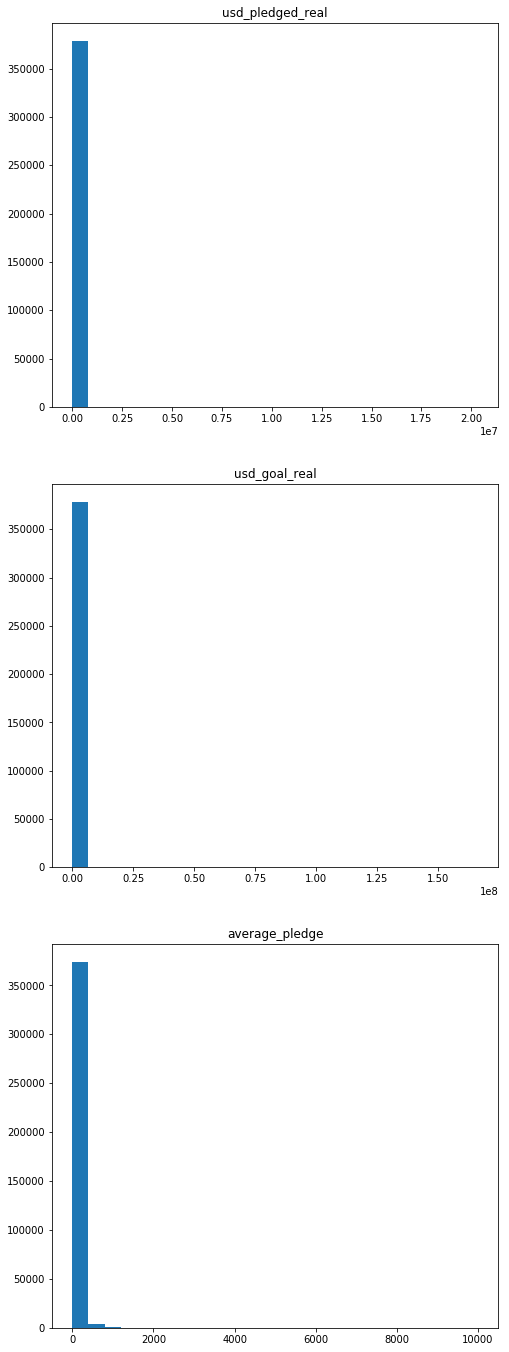

In [191]:
import scipy

numerical_features = X.loc[:, X.dtypes == np.float64]

n_numerical_features = len(numerical_features.columns)

fig, axes = plt.subplots(n_numerical_features, 1, figsize=(8, 8 * n_numerical_features))
for i, c in enumerate(numerical_features.columns.values):
    axes[i].hist(X[c], bins=25)
    axes[i].set_title(c)

There exists a nice `scipy` function which can help us - it is called `boxcox` and it essentially performs log-transformations of the underlying data in order to make it more normal like. Let's look at those plots.

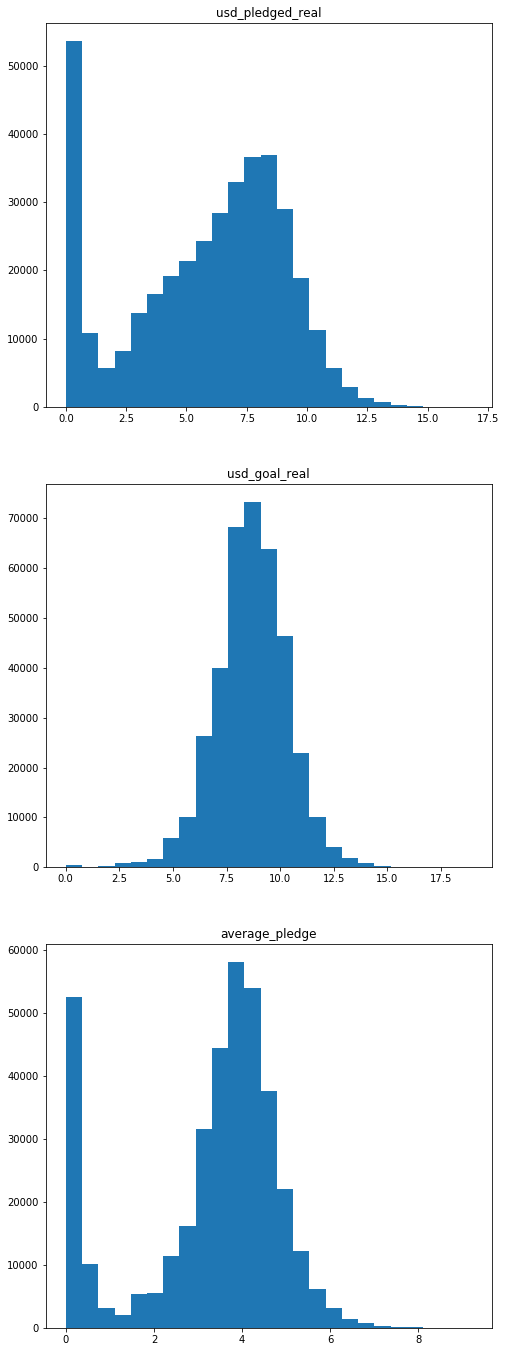

In [194]:
fig, axes = plt.subplots(n_numerical_features, 1, figsize=(8, 8 * n_numerical_features))
for i, c in enumerate(numerical_features.columns.values):
    axes[i].hist(scipy.stats.boxcox(X[c] + 1, 0), bins=25)
    axes[i].set_title(c)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 10 columns):
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
launched            378661 non-null datetime64[ns]
deadline            378661 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 31.8+ MB

Categorical labels encoded.

`backers` column imputed.

Launch_deadline_delta column added.

Training model...
Model accuracy:
Train set:0.9208260708815296
Test set: 0.8806540891133036


Wall time: 1min 8s


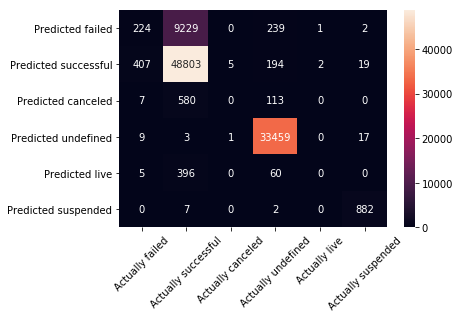

In [120]:
%%time
train(X, y)